# Machine Predictive Maintenance (PdM)

## Introduction

Predictive maintenance techniques are employed to determine the condition of in-service equipment in order to estimate when maintenance should be performed. The main promise of predictive maintenance is to allow convenient scheduling of corrective maintenance, and to prevent unexpected equipment failures. 

In this project I aim to apply predictive maintenance techniques over 100MB of historical data from twenty of the units of a company that failed in the field. The shortest-lived units failed after a few days; the longest-lived units failed after several years. Typical lifetimes are on the order of a year. 

The company has a remote monitoring system for the motors in each unit, which collects information about the motor (rotation speed, voltage, current) as well as two temperature probes (one on the motor and one at the inlet). My objective is to see if there is a similarity in information of the units who had longest lives or shortest lives. The idea is to find a pattern which can help us to determine whether a unit will fail soon or not.

Also, the company has thirty active units working in the field from the past month. My another objective would be to predict which units will fail soon from the available information of previously failed units. 

## Importing Required Libraries

In [8]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn import preprocessing #to normalize data
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()
from sklearn.metrics import confusion_matrix, recall_score, precision_score #to evaluate model performance 

import glob #to find filenames from directory matching a pattern

from scipy.spatial.distance import euclidean #to find euclidean distance between points
from fastdtw import fastdtw #to find DTW distance
from scipy.cluster.hierarchy import ward, dendrogram, fcluster #for hierarchical clustering

#for deep learning
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


## Importing Data

In [2]:
train_files = glob.glob('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\train\\unit*_rms.csv')
test_files = glob.glob('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\test\\unit*_rms.csv')

In [3]:
train_files[0:3]

['C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\train\\unit0000_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\train\\unit0001_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\train\\unit0002_rms.csv']

In [4]:
test_files[0:3]

['C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\test\\unit0020_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\test\\unit0021_rms.csv',
 'C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\test\\unit0022_rms.csv']

Each unit's information is stored in separate file. I am making train and test dataframe which will contain the information of all failed units and currently active units respectively. I am adding three new variables : unit, RUL and cycle. "unit" will have the unit number and "cycle" will be the number of data recording cycle. "RUL" stands for Remaining useful life and it will contain the remaining life of a unit till failure in minutes.

In [5]:
df_train = pd.DataFrame()

for i in range(len(train_files)):
    df0 = pd.read_csv(train_files[i])
    df0["unit"] = i
    df0.timestamp = pd.to_datetime(df0.timestamp)
    failTime = max(df0.timestamp)
    df0["RUL"] = df0.timestamp.apply(lambda x : failTime - x)
    df0["RUL"] = df0["RUL"].astype('timedelta64[m]')
    df0["cycle"] = df0.index + 1

    df_train = pd.concat([df_train,df0])

In [6]:
df_train.head()

timestamp       rpm  motor_voltage  motor_current  \
0 2003-12-13 19:56:43.777979848  0.150438      -0.059544       0.045503   
1 2003-12-13 20:07:32.457298714  0.511660       0.627101       0.208669   
2 2003-12-13 20:13:43.182783330  0.824233       1.732618       0.286401   
3 2003-12-13 20:27:19.295198297  1.506626       3.115258       0.483992   
4 2003-12-13 20:35:08.719032171  2.034869       3.923323       0.851620   

   motor_temp  inlet_temp  unit       RUL  cycle  
0    5.084823    0.019528     0  917140.0      1  
1    7.334172    2.081454     0  917129.0      2  
2    8.843053    3.485346     0  917123.0      3  
3   11.749493    6.041188     0  917109.0      4  
4   12.947061    7.309662     0  917101.0      5

In [17]:
print("df_train has information of total", len(df_train.unit.value_counts().index) , "units.")
print("df_train has", df_train.shape[0], "observations and", df_train.shape[1], "features.")

df_train has information of total 20 units.
df_train has 990133 observations and 9 features.


In [13]:
df_test = pd.DataFrame()

for i in range(len(test_files)):
    df0 = pd.read_csv(test_files[i])
    df0["unit"] = i + 20 
    df0.timestamp = pd.to_datetime(df0.timestamp)
    df0["RUL"] = np.nan
    df0["cycle"] = df0.index + 1

    df_test = pd.concat([df_test,df0])

In [14]:
df_test.head()

timestamp        rpm  motor_voltage  motor_current  \
0 2018-05-01 00:00:53.033586757   0.235075       0.088466       0.048467   
1 2018-05-01 00:10:11.751901322   2.590762       5.120211       1.063173   
2 2018-05-01 00:20:21.452190953   7.679248      14.877355       2.803815   
3 2018-05-01 00:27:39.404285662  10.647193      21.288970       4.320174   
4 2018-05-01 00:38:54.910044761  14.540066      29.243910       5.906701   

   motor_temp  inlet_temp  unit  RUL  cycle  
0    5.029249    0.011926    20  NaN      1  
1    8.542015    2.371336    20  NaN      2  
2   13.513336    5.166404    20  NaN      3  
3   17.407750    7.060859    20  NaN      4  
4   22.570923    9.982019    20  NaN      5

In [16]:
print("df_test has information of total", len(df_test.unit.value_counts().index) , "units.")
print("df_test has", df_test.shape[0], "observations and", df_test.shape[1], "features.")

df_test has information of total 30 units.
df_test has 130699 observations and 9 features.


## Data Cleaning

The remote monitoring system of the company is antiquated and prone to communication errors, which manifest as nonsense measurements. This means there will be many invalid values in a dataset. There might be instances when the values did not get recorded and I will have to do extensive data cleaning to get rid of these errors.

Let's start by inspecting the mean values of each feature unit wise

In [18]:
df_train[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").mean()

rpm  motor_voltage  motor_current    motor_temp    inlet_temp
unit                                                                         
0     -8.111152e+46  -4.431337e+60  -1.387827e+56 -6.640742e+69 -1.937422e+48
1      4.351757e+36  -2.035135e+38  -7.413540e+67 -1.447226e+53 -1.927103e+40
2     -2.689733e+37   2.685303e+35  -1.468081e+30  1.816023e+34 -9.146221e+39
3     2.454681e+110   2.789356e+50   2.447565e+91 -3.153717e+53 -1.177715e+62
4      7.741562e+63  -1.121681e+48   1.492939e+60  8.270559e+56 -1.307910e+76
5      1.695727e+77   3.316074e+81   2.930196e+49 -1.026680e+81 -1.448251e+48
6      4.263050e+67  -4.122228e+64   2.028051e+64 -3.388059e+93 -1.896344e+51
7      1.058303e+51   6.751820e+68  -1.496081e+51  7.068933e+56 -2.138988e+50
8     -9.826381e+38  -4.982600e+48  -2.144675e+41  3.030226e+37 -1.585852e+28
9     -2.019048e+56  -5.835606e+28  -3.617074e+39  3.869137e+39 -1.080940e+30
10    -1.331781e+66   5.830445e+60  -9.329399e+43  1.658088e+36  1.183394e+66
11     1.217051e+44  -3.408161e+48  -2.663043e+85 -1.182668e+80 -3.477070e+69
12     4.009779e+51   1.108656e+55  -3.812729e+47 -1.033432e+65  3.363146e+45
13     7.366644e+35  -2.224854e+31   1.639503e+28  1.434824e+36  1.992872e+47
14    -1.836151e+29  -2.647438e+32   1.079664e+31  2.288937e+82  4.754923e+22
15     2.429545e+31  -9.968325e+48  -1.499532e+34  9.373740e+40 -1.674104e+44
16    -1.143256e+45  -4.329306e+72   1.885734e+42  8.024743e+67 -2.691526e+94
17    -1.446280e+51  -7.872157e+63  -4.387053e+87 -8.459471e+39  9.815985e+49
18     3.089421e+74   9.492944e+66  -4.396280e+46  2.124586e+50 -9.728967e+59
19     1.118511e+56   8.848006e+50   1.784072e+70  1.654122e+78  3.334025e+56

In [19]:
df_test[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").mean()

rpm  motor_voltage  motor_current    motor_temp    inlet_temp
unit                                                                        
20    4.024085e+46  -2.199737e+31   1.835507e+62  8.864209e+30  1.977555e+39
21   -7.145605e+56  -2.671431e+35   1.386158e+68  6.547940e+37 -3.398987e+28
22    1.854290e+31   6.846418e+27  -2.951948e+50  5.439132e+29 -2.275384e+26
23    2.310475e+24   5.787122e+21   1.405893e+17  3.081633e+38  8.353971e+27
24   -2.770103e+28  -6.318672e+28   3.378455e+30 -1.687553e+26  3.410752e+36
25    2.279505e+35  -1.284018e+35  -2.363226e+44 -1.071145e+39  7.790445e+39
26   -8.912164e+59   1.262633e+27   1.589000e+44 -4.795423e+41 -1.340337e+24
27    5.531341e+21  -2.209601e+31  -3.590208e+28 -4.178592e+32  2.353553e+24
28   -1.094062e+23   7.719042e+48  -8.162883e+63  2.701588e+39 -1.529098e+24
29   -1.621468e+53   8.262269e+51  -2.879072e+31  1.026275e+36 -9.255123e+70
30   -5.030824e+41  -2.669471e+39  -4.936401e+20  9.028238e+36 -3.217330e+70
31    1.237395e+53  -1.654247e+48  -4.848200e+27 -6.223688e+27  1.816065e+48
32    7.291189e+19   2.165549e+31   7.393543e+59  4.209985e+26 -1.488670e+47
33    3.480990e+25   3.585289e+26   1.142272e+47 -2.297830e+38  2.279118e+38
34    1.137223e+47   5.133776e+31   5.477604e+28 -3.281553e+36  6.644147e+35
35    1.300871e+32   2.605930e+34  -5.882884e+29 -5.675317e+24  4.339574e+40
36   -6.915326e+34  -6.103911e+34  -1.355552e+34 -2.197940e+28 -9.774420e+39
37   -9.167233e+49  -5.646036e+30   1.618933e+34  3.299195e+50 -8.372599e+30
38   -3.331839e+48  -8.141316e+21   1.046004e+31 -1.006055e+28 -3.495342e+51
39    7.862366e+30   1.040347e+30  -1.939044e+22 -1.222892e+45  1.466918e+38
40    2.983047e+52  -7.437032e+15  -7.520622e+32 -1.190585e+38 -8.935053e+19
41    1.462893e+40  -7.670750e+26   2.732232e+33  1.193727e+44 -8.218161e+27
42   -1.099197e+32  -1.191049e+34   2.941055e+28  2.290054e+52 -2.423500e+40
43   -4.086814e+43   2.074877e+38   4.908004e+24  8.124666e+32  5.478279e+33
44   -3.143753e+43  -2.354828e+26  -2.783034e+26  1.072521e+28  3.873173e+28
45    5.067695e+28  -5.081345e+54  -2.471325e+27  1.925673e+26 -8.260611e+26
46   -3.886695e+36  -4.424446e+36  -2.699509e+34 -5.148420e+25  1.496245e+33
47    1.604444e+24  -9.090254e+37   1.474387e+37 -3.460836e+31 -1.241489e+24
48    1.778203e+19   2.738719e+30  -1.568916e+44  6.481989e+23  1.071388e+73
49    3.087465e+47  -1.040290e+21   2.310808e+31 -2.954602e+35 -1.681077e+14

Mean variable values of all units can be seen above. The mean values go from negative to as high as e+100. This tells us that the data is extremely noisy. Also, higher anomalies can be meant as somethings is wrong with the unit and it will require maintenance soon.

Let's start by removing negative values

In [35]:
feats = ["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]

In [21]:
df_train[df_train[feats] < 0 ] = np.nan
df_test[df_test[feats] < 0 ] = np.nan

Let's deal with the observations which have higher than normal values. The good way to check anomalies to see deviation in recorded values. If the standard deviation is really high, the data contains anomalies. 

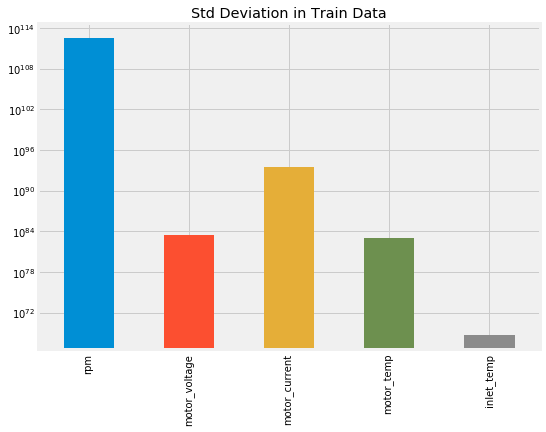

In [22]:
df_train[feats].std().plot(kind='bar', figsize=(8,6), logy=True, title="Std Deviation in Train Data")

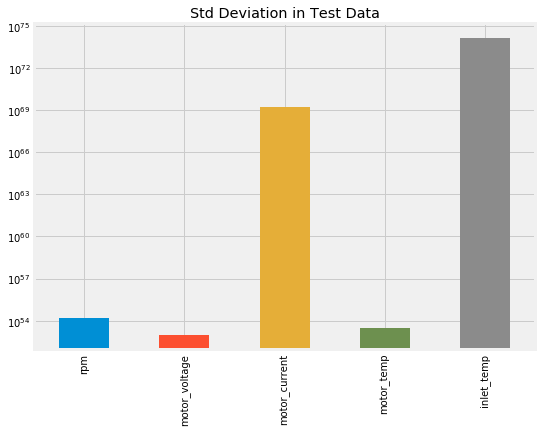

In [23]:
df_test[feats].std().plot(kind='bar', figsize=(8,6), logy=True, title="Std Deviation in Test Data")

The variation is very high in both train and test data. Also, in train data maximum std deviation is in rpm values and minimum in inlet_temp but in test data there is totally opposite scenario. This high standard deviation exsist because of outliers in the data and we will have to remove them. To detect and remove outliers I am using upperbound as 0.99 quantile values of features.

Let's see the 0.99 quantile values of variables unit wise

In [24]:
df_train[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").quantile(0.99)

0.99  inlet_temp  motor_current  motor_temp  motor_voltage          rpm
unit                                                                   
0     202.697844      50.766256  288.964620     333.721535  1220.143592
1     110.235678      50.895190  229.960033     332.370964  1209.970199
2     167.395662      36.072952  224.083056     261.158516  1177.966818
3     161.933479      50.575133  233.507603     331.743069  1213.260502
4     180.899417      50.781358  236.073131     334.429051  1400.771001
5     171.086514      50.226535  240.069645     329.035937  1220.759139
6     158.967629      50.786054  233.563161     332.515302  1217.495940
7     126.454180      50.733095  230.476194     333.783025  1213.892400
8      86.971901      38.204612  148.427662     276.342961  1213.618102
9     109.648758      38.221195  164.201466     269.700720  1193.911974
10    111.337375      51.031135  231.930270     335.074071  1211.508594
11    170.763490      50.568840  234.837819     330.719323  1214.351628
12    127.637232      50.671252  229.965362     332.021555  1218.649964
13     81.203812      33.766178  129.104107     248.079530  1187.811250
14     78.693043      34.801175  131.231615     253.814258  1179.931635
15     80.121906      36.185959  136.207734     264.231873  1193.808330
16    183.827836      50.524891  259.216083     331.147902  1213.968968
17    114.635847      50.524449  228.699503     332.146456  1221.296662
18    146.121217      50.443247  232.398852     330.565879  1211.957325
19    110.631378      50.368669  226.160518     331.582915  1223.468903

In [25]:
df_test[["unit", "rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].groupby("unit").quantile(0.99)

0.99  inlet_temp  motor_current  motor_temp  motor_voltage          rpm
unit                                                                   
20    104.646018      48.891293  220.035749     321.471820  1199.755855
21    226.113872      49.469003  318.743472     323.804334  1200.793808
22    176.625973      49.059459  270.410988     324.081090  1274.206423
23     88.272268      41.626364  169.330393     284.548188  1187.092262
24    107.343005      50.246486  227.333213     327.927334  1196.794736
25    128.106052      49.753613  225.829924     325.077177  1212.707108
26    152.170319      49.797671  225.291688     337.818956  1575.239438
27    241.461922      50.220812  352.246700     348.409819  1582.025695
28    227.586462      50.389033  328.458901     346.723289  1538.580726
29    109.364162      50.305293  228.862838     330.913627  1227.238691
30    227.384593      49.684502  330.750932     323.918668  1203.490044
31    104.473160      49.579860  221.992676     323.969010  1219.764974
32    195.551984      49.142603  270.469572     322.043218  1201.495658
33    107.109778      49.897195  225.423245     327.101027  1211.983021
34    128.972650      49.100845  222.312683     321.343093  1193.841068
35    106.543397      50.017362  222.908472     331.834704  1468.918444
36    170.418792      50.619434  236.613138     332.942741  1284.121893
37    107.243976      50.395003  225.317262     327.900968  1197.661370
38    256.657125      50.728040  376.676674     328.926497  1231.972587
39    104.489200      49.603448  223.750200     323.810619  1205.906522
40    102.338745      48.190351  210.822240     315.556728  1205.852258
41    138.676367      50.307628  230.704427     327.919838  1210.465121
42    202.117290      49.469715  287.242861     321.775131  1195.641907
43    107.888234      50.165849  225.263603     328.570423  1204.389878
44    106.753935      50.336234  226.339121     326.134704  1525.584791
45    161.885727      50.126208  237.738562     325.562459  1230.359770
46    109.576688      50.074116  227.045608     326.857323  1208.238267
47    174.956073      49.749857  270.873995     326.277278  1207.172390
48    106.525991      49.761841  221.767901     325.745380  1240.525362
49    102.665943      48.858961  220.625013     318.272445  1199.002905

By inspecting above values, we can say that these values look legitimate.

Let's see the overall 0.99 quantile values in train and test datasets.

In [26]:
df_train[["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].quantile(0.99)

rpm              1216.766500
motor_voltage     332.063686
motor_current      50.641771
motor_temp        233.116470
inlet_temp        158.663989
Name: 0.99, dtype: float64

In [27]:
df_test[["rpm", "motor_voltage", "motor_current", "motor_temp", "inlet_temp"]].quantile(0.99)

rpm              1217.329007
motor_voltage     327.186630
motor_current      49.952896
motor_temp        260.495304
inlet_temp        184.627932
Name: 0.99, dtype: float64

As we can see 0.99 quantile values in both train and test dataset are very close. For simplicity I am considering an observation as an outlier if it's value goes above 1.5 times the 0.99 quantile value and I am replacing that observation with Null values.

In [29]:
df_train[df_train[feats] > df_train[feats].quantile(0.99)*1.5] = np.nan

In [30]:
df_test[df_test[feats] > df_test[feats].quantile(0.99)*1.5] = np.nan

Let's see the null values in both dataframes.

In [31]:
df_train.isnull().sum()

timestamp            0
rpm              16709
motor_voltage    16988
motor_current    17503
motor_temp       12171
inlet_temp       12238
unit                 0
RUL                  0
cycle                0
dtype: int64

In [25]:
df_test.isnull().sum()

timestamp             0
rpm                2355
motor_voltage      2379
motor_current      2401
motor_temp         1491
inlet_temp         1542
unit                  0
RUL              130699
cycle                 0
dtype: int64

Let's visualize number of instances when values of all the features in a particular unit got recorded wrong.

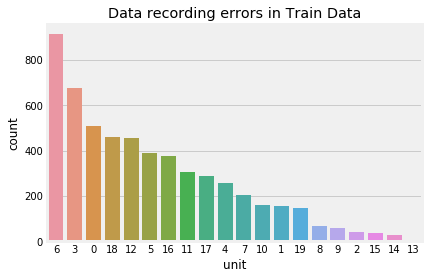

In [32]:
temp_df = df_train[df_train.isnull().sum(axis = 1) == 5] #total variables = 5

plt.title("Data recording errors in Train Data")
sns.countplot(temp_df.unit, order=temp_df.unit.value_counts().index)

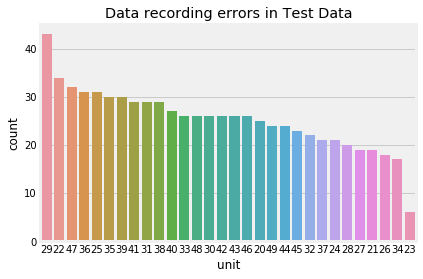

In [33]:
temp_df = df_test[df_test.isnull().sum(axis = 1) == 6] #total variables = 5 + RUL = 6

plt.title("Data recording errors in Test Data")
sns.countplot(temp_df.unit, order=temp_df.unit.value_counts().index)

From above graph, I can form following hypothesis-
#### Hypothesis : If the anomalies in data recording is high, unit does not work as intended and it will have short life.
We can check this hypothesis by comparing data recording errors in unit features with total number of total cycles unit lived.

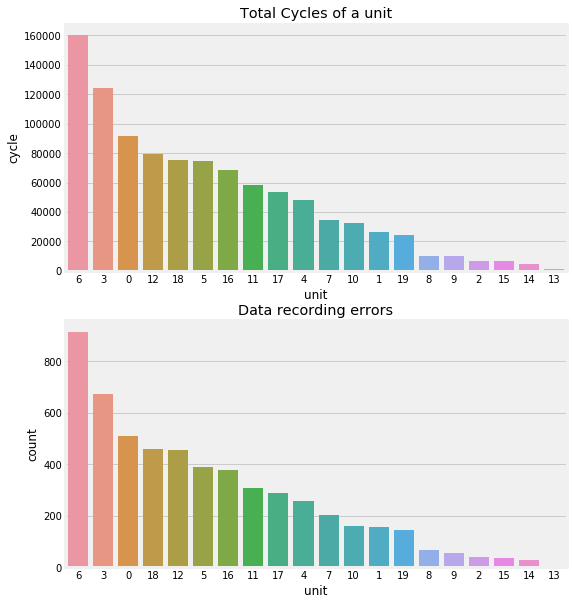

In [35]:
temp_df = df_train[["unit","cycle"]].groupby("unit").max()
temp_df = temp_df.reset_index()

plt.figure(figsize=(8,10))
plt.subplot(211)
plt.title("Total Cycles of a unit")
sns.barplot(x = temp_df.unit, y = temp_df.cycle, order = temp_df.sort_values(by = ["cycle"], ascending= False).unit)

plt.subplot(212)
temp_df = df_train[df_train.isnull().sum(axis = 1) == 5] #total variables = 5

plt.title("Data recording errors")
sns.countplot(temp_df.unit, order=temp_df.unit.value_counts().index)

As we can see the errors in data recording keep increasing with number of cycles. This means that the data recording system has an issue and data recording errors do not tell us about future failure and I can reject my hypothesis.

## Data Imputation

Both of the datasets have lots of null values and I will have to deal with them. To impute the null values in data, first let's check if there is a trend in our data.

#### Unit 0 Feature Values Plots

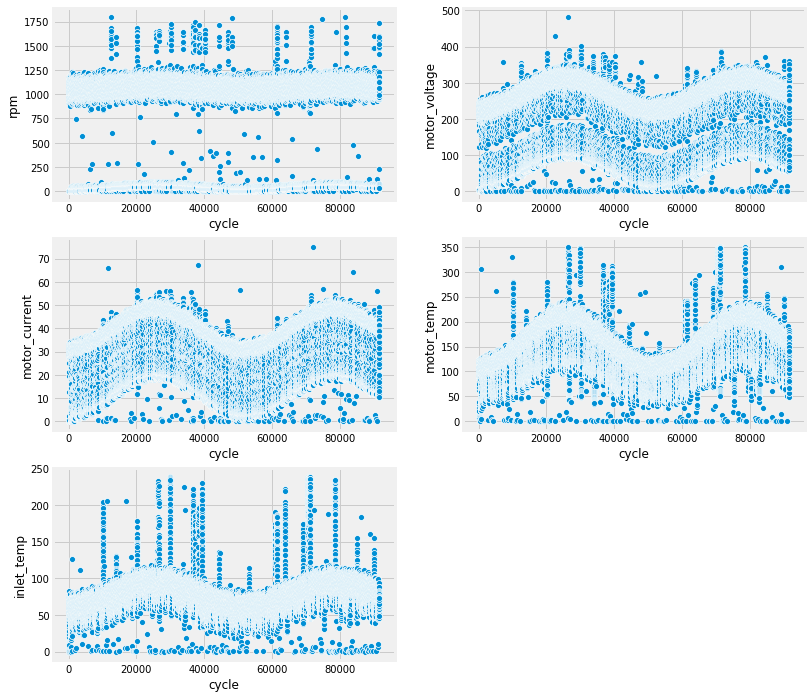

In [29]:
temp_df = df_train[df_train.unit == 0]
plt.figure(figsize = (12,12))

plt.subplot(321)
sns.scatterplot(x = temp_df.cycle, y = temp_df.rpm)

plt.subplot(322)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_voltage)

plt.subplot(323)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_current)

plt.subplot(324)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_temp)

plt.subplot(325)
sns.scatterplot(x = temp_df.cycle, y = temp_df.inlet_temp)


#### Unit 1 Feature Values Plots

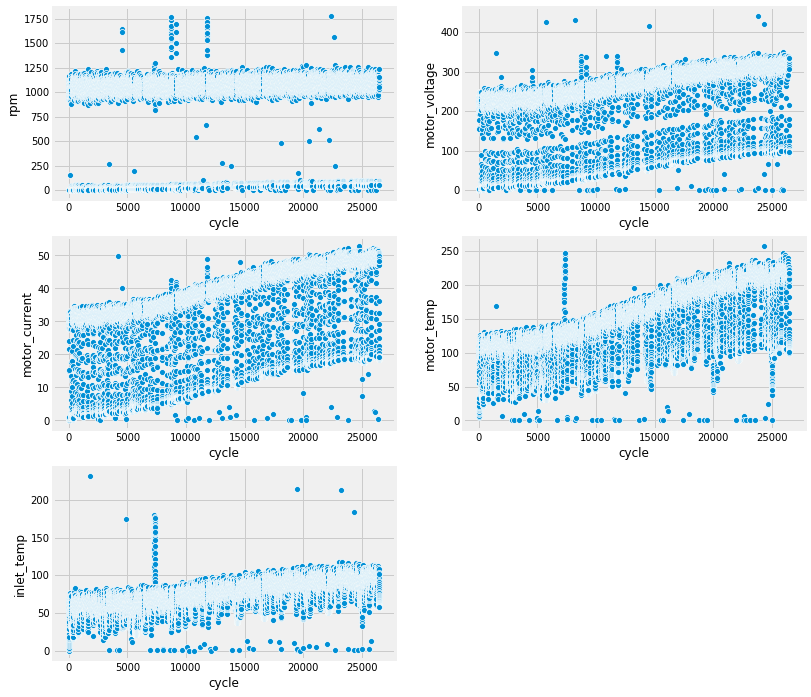

In [30]:
temp_df = df_train[df_train.unit == 1]
plt.figure(figsize = (12,12))

plt.subplot(321)
sns.scatterplot(x = temp_df.cycle, y = temp_df.rpm)

plt.subplot(322)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_voltage)

plt.subplot(323)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_current)

plt.subplot(324)
sns.scatterplot(x = temp_df.cycle, y = temp_df.motor_temp)

plt.subplot(325)
sns.scatterplot(x = temp_df.cycle, y = temp_df.inlet_temp)

From above graphs we can say that the value of rpm almost remains constant and all other features are highly correlated with eachother. We can fill the null values of data with rolling average as in this sequential data most of the time features have values similar to past cycle's values. Here, I am making an assumption that feature values do not increase or descrease abruptly. For filling null values with rolling mean I use center method with window size = 6 including the null value.

I will run iterations untill all the values in dataframe get filled by rolling mean. Also, there are chances of introducing bias as these might not be true values but we will have to take the risk. Null values are not many compared to overall dataset so, imputing rolling mean should not affect our results much.

In [36]:
while((df_train[feats].isnull().sum() > 0).values.sum()):
    df_train[feats] = df_train[feats].fillna(df_train[feats].rolling(min_periods=1, center=True, window=6).mean())

In [37]:
while((df_test[feats].isnull().sum() > 0).values.sum()):
    df_test[feats] = df_test[feats].fillna(df_test[feats].rolling(min_periods=1, center=True, window=6).mean())

In [38]:
df_train.isnull().sum()

timestamp        0
rpm              0
motor_voltage    0
motor_current    0
motor_temp       0
inlet_temp       0
unit             0
RUL              0
cycle            0
dtype: int64

In [39]:
df_test.isnull().sum()

timestamp             0
rpm                   0
motor_voltage         0
motor_current         0
motor_temp            0
inlet_temp            0
unit                  0
RUL              130699
cycle                 0
dtype: int64

As we can see, now the datasets have no null values except RUL of a test data. Test dataset is having null values because units are currently working.  

## Exploratory Data Analysis

First of all lets's visualize feature values of units having maximum life and having minimum life to see if there is any pattern in feature values.

In [41]:
df_train[["unit","cycle"]].groupby("unit").max().sort_values(by = ["cycle"], ascending= False).head(5)

cycle
unit        
6     159982
3     124073
0      91715
12     79175
18     75193

In [42]:
df_train[["unit","cycle"]].groupby("unit").max().sort_values(by = ["cycle"], ascending= False).tail(5)

cycle
unit       
9     10058
2      6671
15     6503
14     4711
13     1428

In [66]:
#function to plot feature values for specific unit
def plot(df):
    
    plt.figure(figsize = (12,12))

    plt.subplot(321)
    sns.scatterplot(x = df.cycle, y = df.rpm)

    plt.subplot(322)
    sns.scatterplot(x = df.cycle, y = df.motor_voltage)

    plt.subplot(323)
    sns.scatterplot(x = df.cycle, y = df.motor_current)

    plt.subplot(324)
    sns.scatterplot(x = df.cycle, y = df.motor_temp)

    plt.subplot(325)
    sns.scatterplot(x = df.cycle, y = df.inlet_temp)
    plt.plot()

### Top five units having maximum life

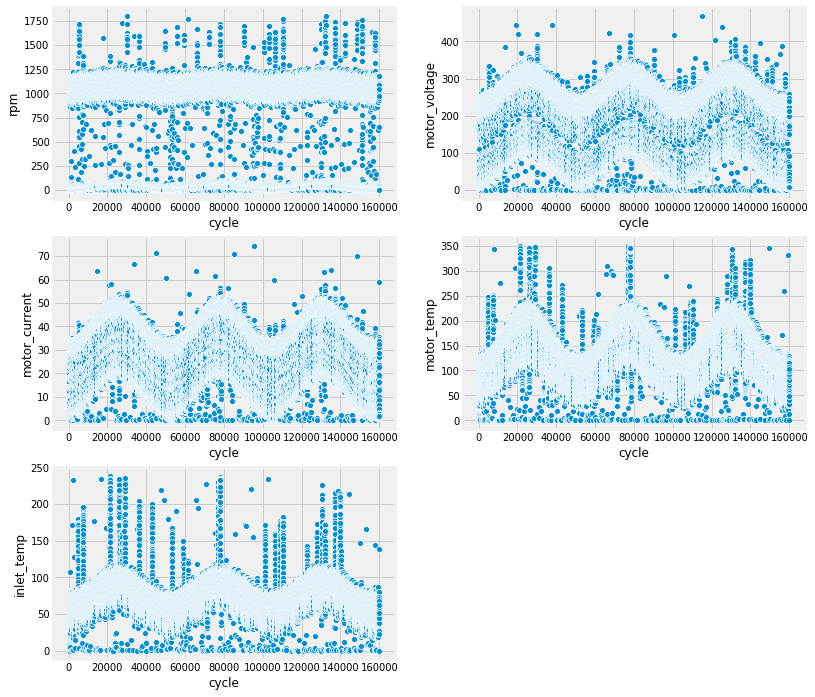

In [111]:
plot(df_train[df_train.unit == 6])

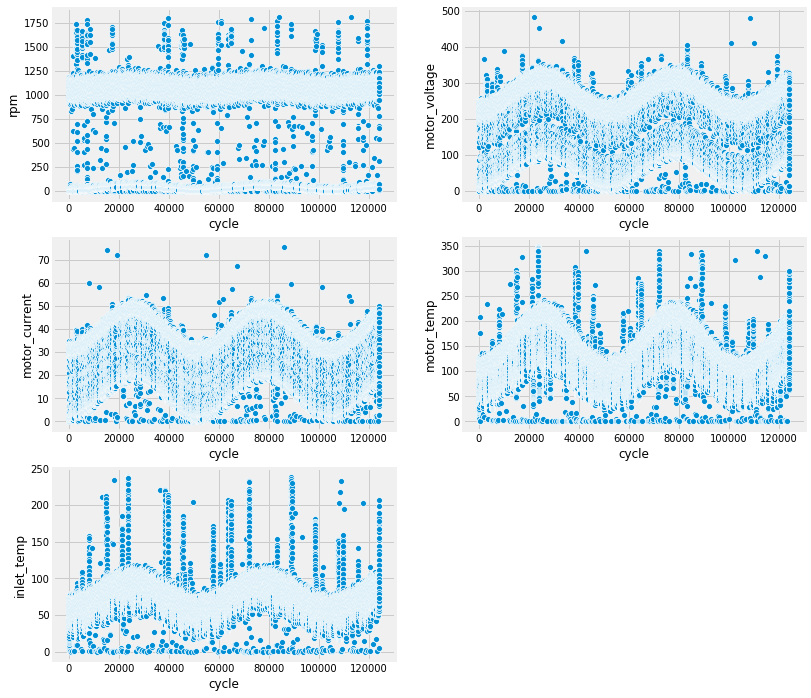

In [112]:
plot(df_train[df_train.unit == 3])

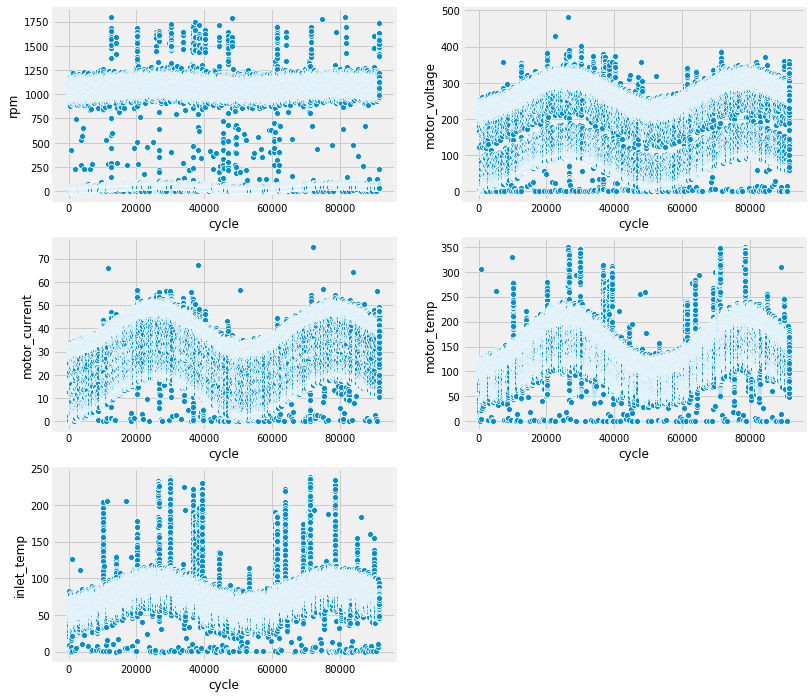

In [113]:
plot(df_train[df_train.unit == 0])

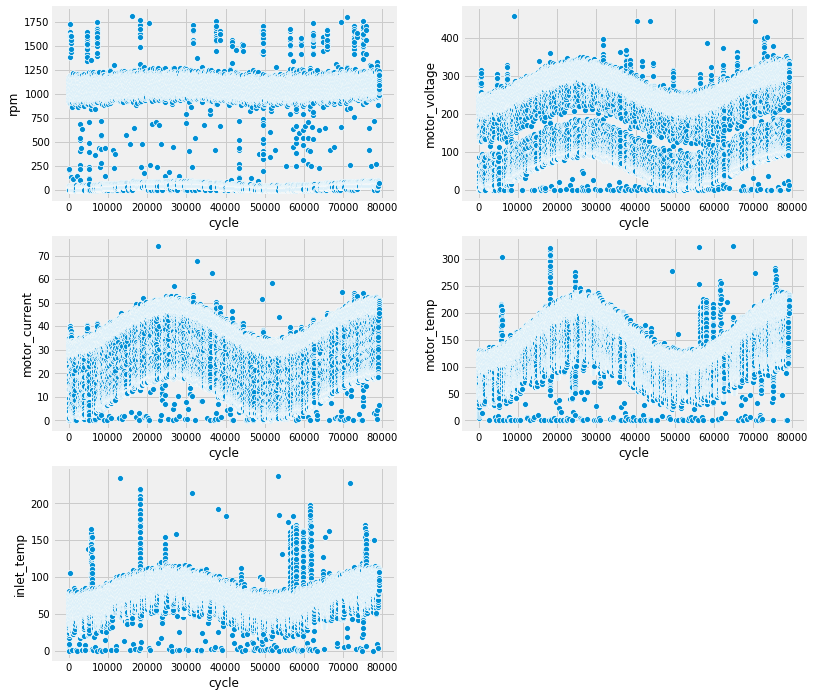

In [114]:
plot(df_train[df_train.unit == 12])

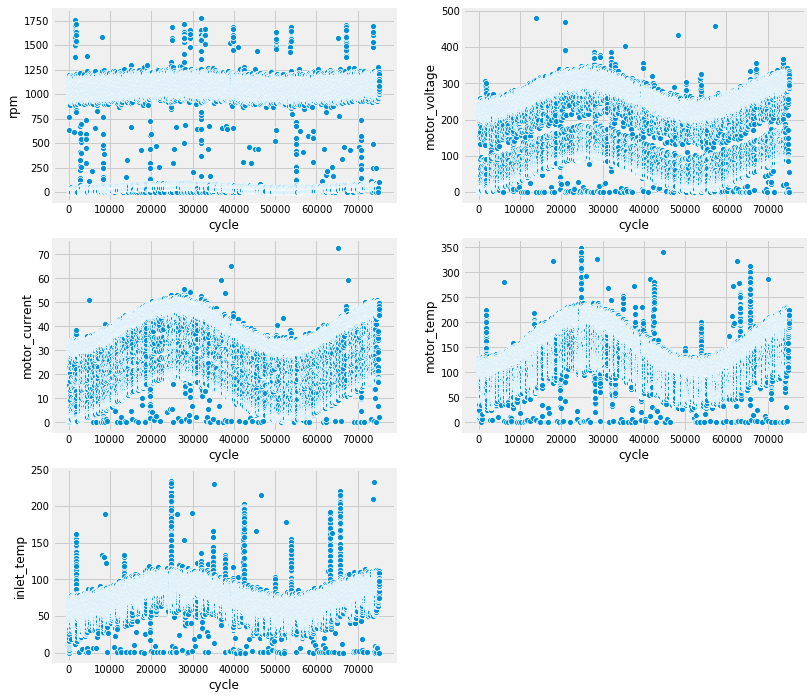

In [115]:
plot(df_train[df_train.unit == 18])

### Top five units having minimum RUL

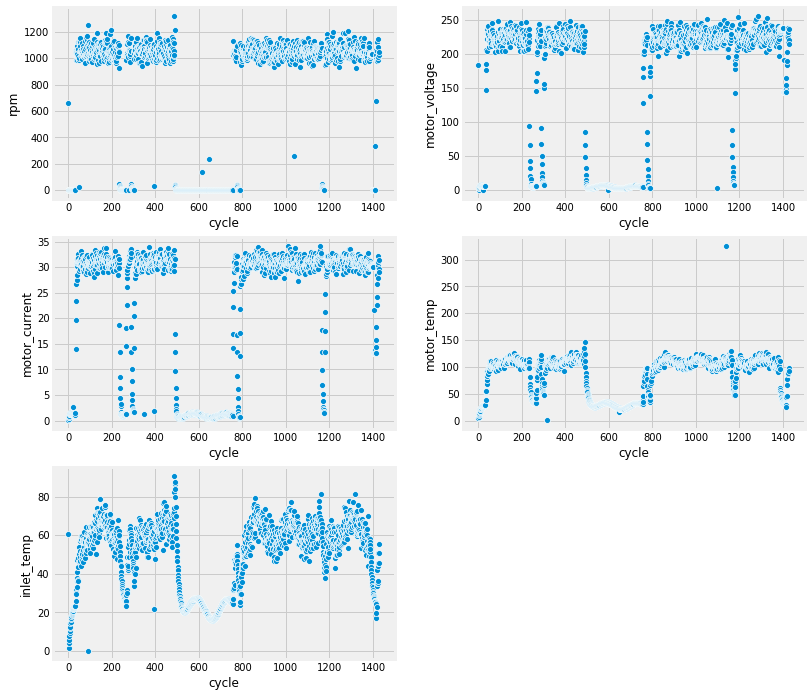

In [116]:
plot(df_train[df_train.unit == 13])

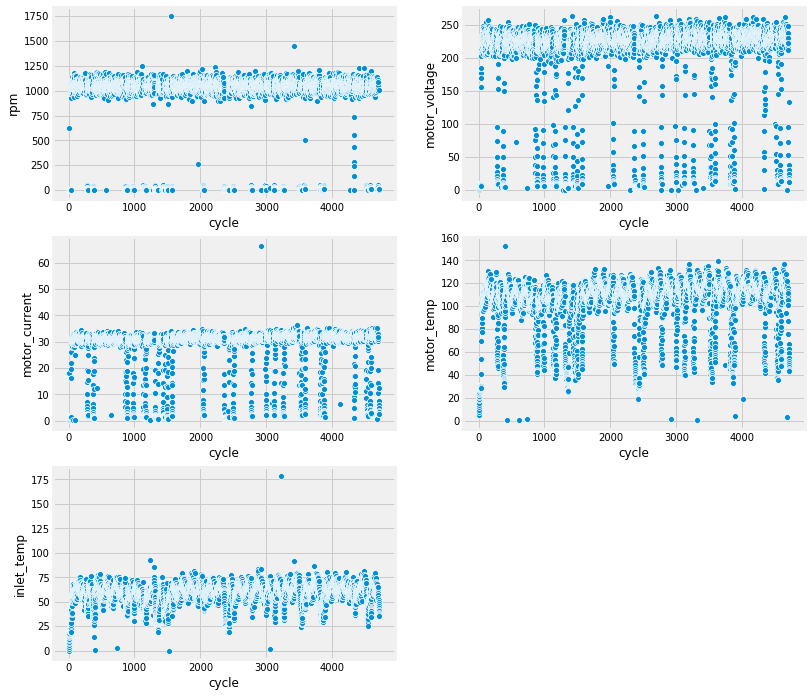

In [117]:
plot(df_train[df_train.unit == 14])

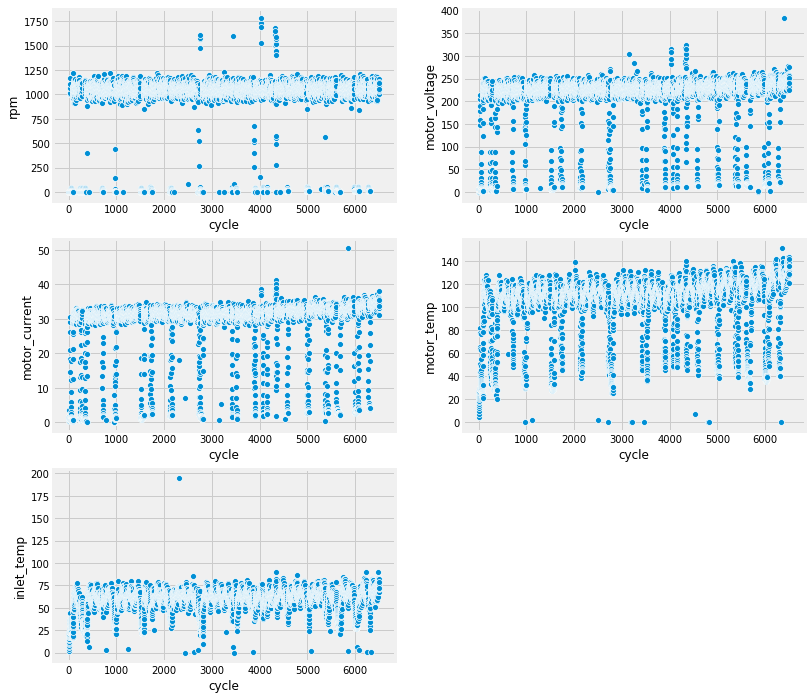

In [118]:
plot(df_train[df_train.unit == 15])

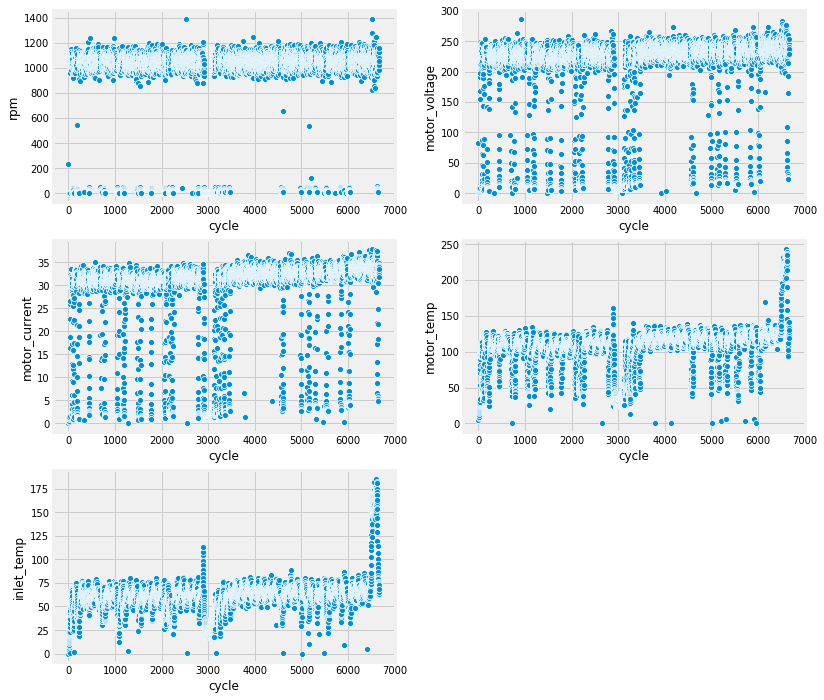

In [119]:
plot(df_train[df_train.unit == 2])

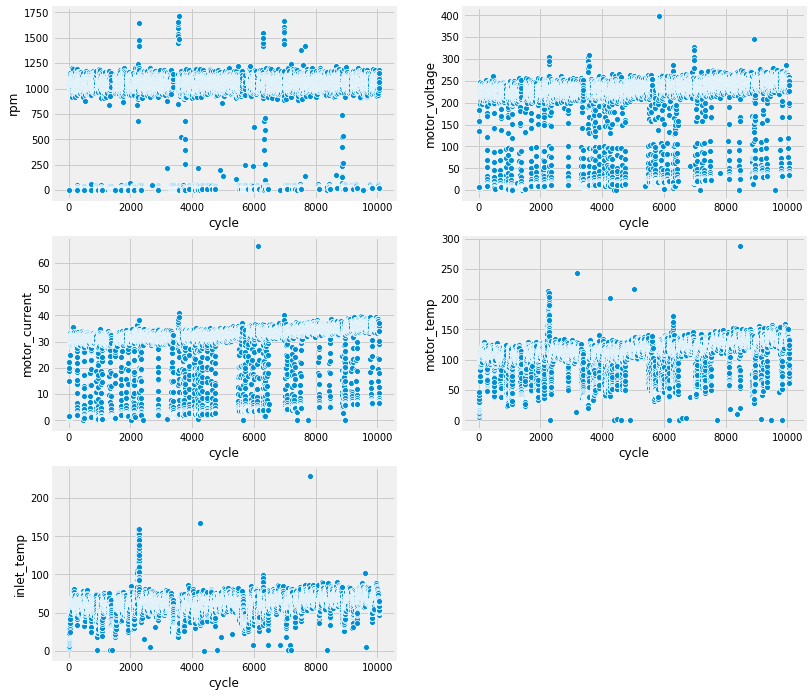

In [120]:
plot(df_train[df_train.unit == 9])

If we compare feature value plots of units having maximum life with units having minimum life we can clearly see the difference. We can say the following things:
- inlet_temp, motor_temp, motor_current and motor_coltage plots of Units having maximum life follow cyclic pattern whereas thses plots of Units having minimum life almost remains constant.
- There is a high correlation in inlet_temp, motor_temp, motor_current and motor_voltage.
- rpm remains almost constant.

### Let's see correlation between these features.

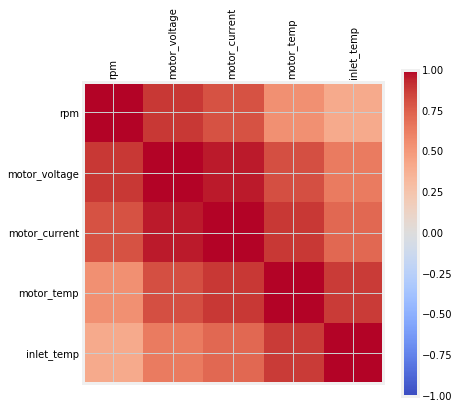

In [44]:
corr = df_train[feats].corr()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)

ticks = np.arange(0,len(df_train[feats].columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_train[feats].columns)
ax.set_yticklabels(df_train[feats].columns)
plt.show()

In [45]:
corr

rpm  motor_voltage  motor_current  motor_temp  inlet_temp
rpm            1.000000       0.885954       0.803429    0.545079    0.406921
motor_voltage  0.885954       1.000000       0.956631    0.806164    0.638916
motor_current  0.803429       0.956631       1.000000    0.884157    0.712539
motor_temp     0.545079       0.806164       0.884157    1.000000    0.877952
inlet_temp     0.406921       0.638916       0.712539    0.877952    1.000000

The maximum correlation is between motor_voltage and motor_current which is 0.956. Also, there is a high correlation between rpm and motor_voltage and rpm and motor_current. Power increases if rpm increases and since Power = Voltage * Current, voltage and current also increase.

Let's see plots of feature values of unit 0. It is one of the units having maximum lives.

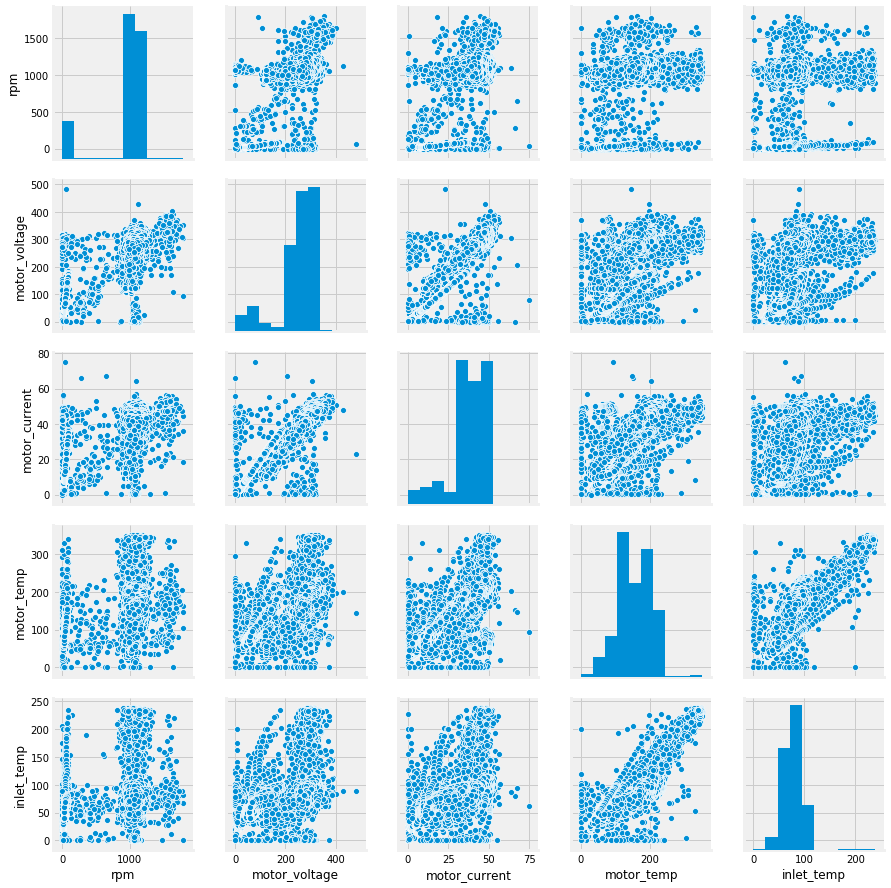

In [47]:
sns.pairplot(data = df_train[feats][df_train.unit == 0], kind = 'scatter')

As we can see, there is no definite pattern and I will have to keep all features in analysis.

### Let's visualize how feature values get recorded before units fail.

C:\Users\archd\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1241: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


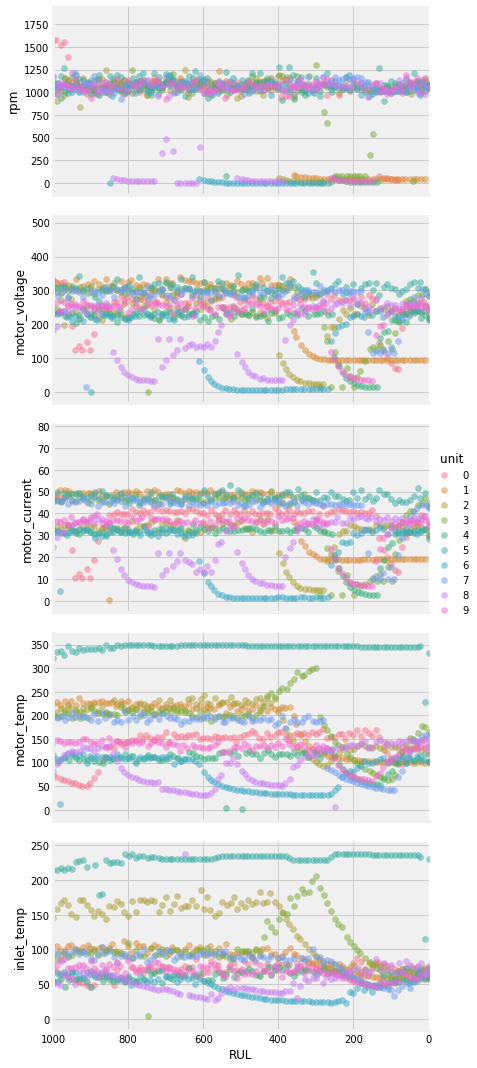

In [48]:
pairPlot = sns.PairGrid(data = df_train[df_train.unit < 10], x_vars = "RUL", y_vars = feats, hue = "unit", size = 3, aspect = 2)
pairPlot = pairPlot.map(plt.scatter, alpha = 0.5)
pairPlot = pairPlot.set(xlim = (1000, 0))
pairPlot = pairPlot.add_legend()

As we can see feature do not have specific values before the failure of the unit.

### Let's see the last recorded values before unit failure

In [49]:
df_train[df_train.RUL == 0]

timestamp          rpm  motor_voltage  \
91714  2005-09-10 17:36:47.236452969  1066.459970     252.919940   
26459  2004-09-14 19:52:23.407568800  1047.879219     215.758439   
6670   2004-04-17 02:57:14.275484023  1054.495392     228.990784   
124072 2006-04-22 01:15:10.936547367  1082.218577     284.437154   
48124  2004-01-24 06:33:14.224596987  1049.864747     219.729495   
74648  2005-12-29 23:51:07.480417862  1087.075241     294.150482   
159981 2006-05-01 23:27:34.021806751  1046.287852     212.575703   
34804  2005-07-08 06:41:18.934252789  1081.520827     283.041653   
10223  2003-07-10 14:13:49.770634205  1061.216273     242.432547   
10057  2005-03-04 13:53:46.364587460  1060.499456     240.998913   
32152  2004-02-19 08:30:03.951266300  1081.588253     283.176506   
58174  2005-10-05 19:08:44.088967399  1009.420700     138.841400   
79174  2006-03-18 21:42:54.623657935  1088.997360     297.994719   
1427   2003-07-16 12:26:37.983169605  1047.606174     215.212348   
4710   2004-02-08 22:44:12.915194316  1006.303225     132.606449   
6502   2003-07-01 23:32:56.072840965  1052.785960     225.571921   
68434  2005-11-15 22:22:58.027780871  1046.302048     212.604097   
53250  2005-06-13 12:39:06.050522500  1044.414388     208.828776   
75192  2005-03-08 21:43:34.423520403  1087.130570     294.261140   
24346  2005-04-11 19:07:25.070826388  1126.291727     315.359224   

        motor_current  motor_temp  inlet_temp  unit  RUL   cycle  
91714       36.583988  140.631292   73.711883     0  0.0   91715  
26459       29.151688  100.382530   57.891485     1  0.0   26460  
6670        31.798157  118.677196   68.121057     2  0.0    6671  
124072      42.887431  165.659226   73.692640     3  0.0  124073  
48124       29.945899  103.254062   58.416219     4  0.0   48125  
74648       44.830096  331.286249  230.799372     5  0.0   74649  
159981      28.515141  102.351343   61.695680     6  0.0  159982  
34804       42.608331  154.793857   64.020365     7  0.0   34805  
10223       34.486509  135.726620   76.260654     8  0.0   10224  
10057       34.199783  123.849606   65.368350     9  0.0   10058  
32152       42.635301  170.208273   79.319827    10  0.0   32153  
58174       13.768280   55.163192   45.684915    11  0.0   58175  
79174       45.598944  199.974454   96.011270    12  0.0   79175  
1427        29.042470   92.995067   50.821815    13  0.0    1428  
4710        12.521290   43.449411   35.610276    14  0.0    4711  
6502        31.114384  120.749413   72.344168    15  0.0    6503  
68434       28.520819   99.907443   59.235586    16  0.0   68435  
53250       27.765755   97.730830   59.183972    17  0.0   53251  
75192       44.852228  198.698644   98.112526    18  0.0   75193  
24346       49.743079  224.954185  105.147035    19  0.0   24347

In [50]:
df_train[feats].mean()

rpm              940.762569
motor_voltage    239.903630
motor_current     35.778584
motor_temp       147.386490
inlet_temp        74.922421
dtype: float64

If we check the values recorded before unit failure we can see that most of the values are above mean. But we cannot say with higher confidence that successive higher values than normal values lead to unit failure.

Saving cleaned datasets as csv files.

In [95]:
df_train.to_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\cleaned_train.csv', sep='\t', index = False)
df_test.to_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\cleaned_test.csv', sep='\t', index = False)

In [87]:
df_train = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\cleaned_train.csv', sep='\t')
df_test = pd.read_csv('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\cleaned_test.csv', sep='\t')

In [88]:
df_train.timestamp = pd.to_datetime(df_train.timestamp)
df_test.timestamp = pd.to_datetime(df_test.timestamp)

## Clustering

### Dynamic Time Warping

Dynamic Time Warping (DTW) is a way to find similarity between two time series, while they could be shifted in time. Dynamic time warping finds the optimal non-linear alignment between two time series. The Euclidean distances between alignments are then much less susceptible to pessimistic similarity measurements due to distortion in the time axis. There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used.

My first choice to perform clustering was K-Means as I love that algorithm but we cannot use K-Means clustering for timeseries. DTW is not minimized by the mean; k-means may not converge and even if it converges it will not yield a very good result. The mean is an least-squares estimator on the coordinates. It minimizes variance, not arbitrary distances, and k-means is designed for minimizing variance, not arbitrary distances.

I am using DTW to make a distance matrix for all units. My objective is to see if there is a similarity in recorded values of units. It will help us to know if there is any pattern in recorded values that can help us say unit will live longer or shorter.

In [89]:
#initializing matrix of size (20,20) as we have 20 units and there will be total 400 distance values between each and every unit
distance_matrix = np.zeros((20,20))

In [90]:
#creating different time series unit wise
df = {}
for i in range(0,20):
    df[i] = df_train[feats][df_train.unit == i]
    df[i] = standardScaler.fit_transform(df[i]) #scaling the values as DTW calculation will be faster

In [91]:
#finding DTW distances and saving them in the distance matrix
for i in range(0,20):
    for j in range(0,20):
        distance_matrix[i,j], _ = fastdtw(df[i], df[j], dist=euclidean)

In [67]:
#Saving the matrix as calculating DTW distance takes time and also to use it later directly
np.save('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\distance_matrix.npy', distance_matrix)

In [95]:
distance_matrix = np.load('C:\\Users\\archd\\OneDrive\\Desktop\\Tagup\\data-science\\distance_matrix.npy')

In [96]:
distance_matrix

array([[     0.        , 113960.40749771, 117985.32297118,
        142200.76443474, 116644.62321894,  91902.0551032 ,
        192005.68144902, 111227.39046643, 112148.2181407 ,
        118440.95988943, 104851.36387679, 129746.3859818 ,
         89639.79310327, 121034.01510443, 122403.92514422,
        130080.07946607,  93160.58475342, 125743.8901658 ,
         87368.00581174, 108669.63215516],
       [113761.5513363 ,      0.        ,  32341.39710962,
        165596.64504453,  54112.24990614,  98695.62805401,
        213263.54244441,  31670.75708042,  30589.83565715,
         28417.34927588,  29102.24206778,  71244.88170318,
        101868.17604529,  35589.75644284,  33659.24037802,
         33123.4437194 ,  91463.58165594,  61523.72763184,
         89747.86807888,  20996.95215783],
       [117466.66432148,  33195.4981227 ,      0.        ,
        165418.81003576,  60324.06687986,  98712.74547365,
        211651.28058414,  42915.48770788,  12394.73196469,
         10985.50428884,  398

### Hierarchical Clustering

Hierarchical Clustering is a method of cluster analysis which seeks to build a hierarchy of clusters. I am using agglomerative (bottom-up) approach with DTW distance matrix. This helps us to know which units yielded similar feature values before failure.

C:\Users\archd\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\archd\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
C:\Users\archd\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


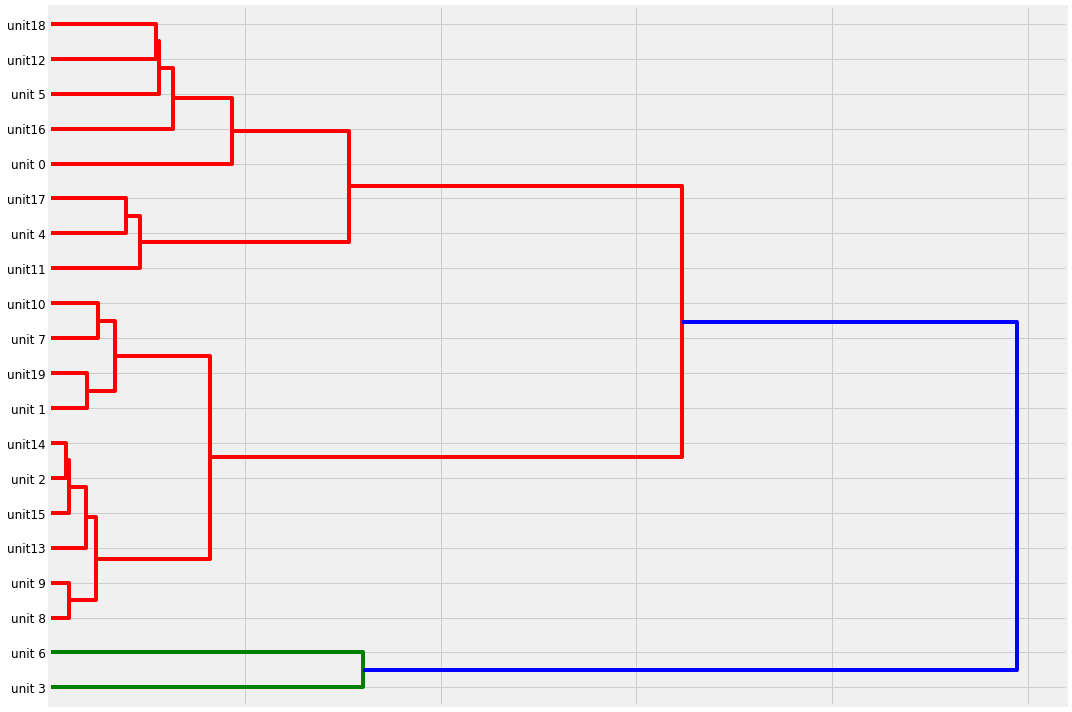

In [97]:
linkage_matrix = ward(distance_matrix) #ward's minimum variance method for bottom-up approach

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", labels=["unit{:2d}".format(x) for x in range(0,20)]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#saving figure
plt.savefig('unit_clusters.png', dpi=200);

Let's make 4 clusters linkage_matrix

In [98]:
clusters = fcluster(linkage_matrix, 3, criterion='maxclust')
clusters

array([3, 2, 2, 1, 3, 3, 1, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 2],
      dtype=int32)

In [99]:
temp_df = df_train[["unit","cycle"]].groupby("unit").max()
temp_df = temp_df.reset_index()
temp_df["cluster"] = clusters
temp_df = temp_df.sort_values(by = ["cycle"], ascending= False)
temp_df.set_index("unit")

cycle  cluster
unit                 
6     159982        1
3     124073        1
0      91715        3
12     79175        3
18     75193        3
5      74649        3
16     68435        3
11     58175        3
17     53251        3
4      48125        3
7      34805        2
10     32153        2
1      26460        2
19     24347        2
8      10224        2
9      10058        2
2       6671        2
15      6503        2
14      4711        2
13      1428        2

As we can see clustering happens based on a cycle length and there are neat clusters. Since, we have different size of data from different units i.e. lives of units are different, clustering does not help us predict what leads to failure.

## Classification

### Data Preprocessing


To make sure that variance of features remain in the same range, it is important to scale the features. If a feature's variance is order of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not desirable.

In [36]:
# MinMax normalization (from 0 to 1)
min_max_scaler = preprocessing.MinMaxScaler()

norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(df_train[feats]), 
                             columns=feats, 
                             index=df_train.index)

join_df = df_train[df_train.columns.difference(feats)].join(norm_train_df)

df_train = join_df.reindex(columns = df_train.columns)


norm_test_df = pd.DataFrame(min_max_scaler.fit_transform(df_test[feats]), 
                             columns=feats, 
                             index=df_test.index)

join_df = df_test[df_test.columns.difference(feats)].join(norm_test_df)

df_test = join_df.reindex(columns = df_test.columns)

In [37]:
df_train.head()

timestamp       rpm  motor_voltage  motor_current  \
0 2003-12-13 19:56:43.777979848  0.000083       0.002380       0.000596   
1 2003-12-13 20:07:32.457298714  0.000281       0.001264       0.002757   
2 2003-12-13 20:13:43.182783330  0.000453       0.003495       0.003786   
3 2003-12-13 20:27:19.295198297  0.000828       0.006286       0.006402   
4 2003-12-13 20:35:08.719032171  0.001118       0.007916       0.011270   

   motor_temp  inlet_temp  unit       RUL  cycle  
0    0.014542    0.000081     0  917140.0      1  
1    0.020974    0.008745     0  917129.0      2  
2    0.025290    0.014644     0  917123.0      3  
3    0.033602    0.025383     0  917109.0      4  
4    0.037027    0.030713     0  917101.0      5

In [38]:
df_test.head()

timestamp       rpm  motor_voltage  motor_current  \
0 2018-05-01 00:00:53.033586757  0.000127       0.000178       0.000611   
1 2018-05-01 00:10:11.751901322  0.001420       0.010492       0.014158   
2 2018-05-01 00:20:21.452190953  0.004215       0.030492       0.037396   
3 2018-05-01 00:27:39.404285662  0.005844       0.043634       0.057640   
4 2018-05-01 00:38:54.910044761  0.007982       0.059940       0.078820   

   motor_temp  inlet_temp  unit  RUL  cycle  
0    0.012970    0.000036    20  NaN      1  
1    0.022029    0.008596    20  NaN      2  
2    0.034851    0.018736    20  NaN      3  
3    0.044895    0.025609    20  NaN      4  
4    0.058212    0.036207    20  NaN      5

### Binary Classification

The company has thirty active units working in the field from past month. My objective is to predict which units will fail within a certail time frame and I am considering certain time frame as 600 minutes ~ 60 cycles. This is a binary classification problem and as a target I will create a feature named "label" which will have values either 0 or 1 depending upon RUL of a unit at a given time.

In [39]:
threshold_RUL = 600
df_train['label'] = np.where(df_train['RUL'] <= threshold_RUL, 1, 0 )

I am using Long Short-Term Memory network or LSTM network for this classification as it is a powerful type of Neural Network designed to handle time series sequence dependence. The idea of using LSTMs is to let the model extract abstract features out of the sequence from the window rather than engineering those manually. The expectation is that if there is a pattern in these feature values within the window prior to failure, the pattern should be encoded by the LSTM.

We have test data of 30 units containing feature values recorded since past thirty days and we have lots of training data. I am using training data which have RUL less than 70000 minutes (~past 50 days) considering my machine's configurations. We should have good results with this much of data. 

In [40]:
df_train = df_train[df_train.RUL < 70000]


Keras LSTM layers expect an input in the shape of a numpy array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps (the look back window or sequence length) and features (the number of features of each sequence at each time step).

In [43]:
# keeping window size = 50 cycles
sequence_length = 50

# function to reshape features into (samples, time steps, features) 
# no padding is used
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

In [44]:
# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [45]:
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['unit']==unit], sequence_length, feats)) for unit in df_train['unit'].unique()))
print(X_train.shape)

(131296, 50, 5)


In [46]:

# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['unit']==unit], sequence_length, feats,'label')) for unit in df_train['unit'].unique()))
print(y_train.shape)

(131296,)


Now, this classification problem has an issue of class imbalance. In this situation, the predictive model developed using conventional machine learning algorithms could be biased and inaccurate. This happens because Machine Learning Algorithms are usually designed to improve accuracy by reducing the error. Thus, they do not take into account the balance of classes. To deal with this problem I will give higher weightage to class having less value i.e. 1 in our case.  

In [47]:
class_weight = {0 : 1,
                1 : 20}

### Model

I am using Sequential model with first layer as an LSTM layer with 100 units followed by another LSTM layer with 50 units. I will also apply Dropout after each LSTM layer to control overfitting. Final layer will be a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.

In [48]:
nb_features = X_train.shape[2]
timestamp = sequence_length

model = Sequential()
model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           42400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 72,651
Trainable params: 72,651
Non-trainable params: 0
_________________

Fitting the model with class weight:

In [49]:
model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.1, verbose=1, class_weight = class_weight,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Instructions for updating:
Use tf.cast instead.
Train on 118166 samples, validate on 13130 samples
Epoch 1/10
118166/118166 [==============================] - 79s 671us/step - loss: 0.5137 - acc: 0.9897 - val_loss: 0.5166 - val_acc: 0.9908
Epoch 2/10
118166/118166 [==============================] - 84s 710us/step - loss: 0.4757 - acc: 0.9893 - val_loss: 0.5187 - val_acc: 0.9908


Let's see the model score.

In [50]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

131296/131296 [==============================] - 36s 277us/step
Accurracy: 0.9910126735263123


Accuracy of the model is 99.101% which is not astonishing as we have a very large dataset with class imbalance.

In [51]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(X_train)
y_true = y_train
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[129974,    109],
       [  1071,    142]], dtype=int64)

In [78]:
print("Model's Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Model's Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))

Model's Precision: 0.9991620734454156
Model's Recall: 0.9918272349193026


Let's predict the results for Test data using trained model.

In [53]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['unit']==unit], sequence_length, feats)) for unit in df_test['unit'].unique()))
print(X_test.shape)

(130669, 50, 5)


In [54]:
#creating label variable for test dataset
df_test["label"] = np.nan

# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['unit']==unit], sequence_length, feats,'label')) for unit in df_test['unit'].unique()))
print(y_test.shape)

(130669,)


Creating a function which will give the probability of a unit failure.

In [59]:
def prob_failure(unit_no):
    
    unit_df=df_test[df_test.unit == unit_no]
    unit_test = gen_sequence(unit_df,sequence_length,feats)
    m_pred = model.predict(unit_test)
    failure_prob=list(m_pred[-1]*100)[0]
    
    return failure_prob

In [60]:
#creating a dataframe
failure_prob_df = pd.DataFrame(columns=['unit', 'Failure Probability'])

Let's find probabilities of a unit failure in 50 cycles ~ 500 minutes.

In [63]:
unit_no=range(20,50)
for i in unit_no:
    fail_prob = prob_failure(i)
    failure_prob_df = failure_prob_df.append({'unit': i, 'Failure Probability' : fail_prob},ignore_index = True)
    print("Probability that unit", i, "will fail within 50 cycles: ",fail_prob)
    

Probability that unit 20 will fail within 50 cycles:  13.000965
Probability that unit 21 will fail within 50 cycles:  13.187981
Probability that unit 22 will fail within 50 cycles:  13.228684
Probability that unit 23 will fail within 50 cycles:  14.415942
Probability that unit 24 will fail within 50 cycles:  17.598253
Probability that unit 25 will fail within 50 cycles:  16.337547
Probability that unit 26 will fail within 50 cycles:  13.013736
Probability that unit 27 will fail within 50 cycles:  13.129425
Probability that unit 28 will fail within 50 cycles:  13.145054
Probability that unit 29 will fail within 50 cycles:  13.076085
Probability that unit 30 will fail within 50 cycles:  13.092229
Probability that unit 31 will fail within 50 cycles:  13.317787
Probability that unit 32 will fail within 50 cycles:  13.066706
Probability that unit 33 will fail within 50 cycles:  13.140202
Probability that unit 34 will fail within 50 cycles:  13.143453
Probability that unit 35 will fail withi

In [65]:
failure_prob_df.sort_values(by = ['Failure Probability'], ascending= False)

unit  Failure Probability
4   24.0            17.598253
20  40.0            17.254513
15  35.0            16.573563
5   25.0            16.337547
3   23.0            14.415942
18  38.0            14.004186
27  47.0            13.341099
21  41.0            13.339946
11  31.0            13.317787
24  44.0            13.247553
23  43.0            13.243813
17  37.0            13.229320
2   22.0            13.228684
19  39.0            13.226262
1   21.0            13.187981
16  36.0            13.157699
29  49.0            13.154613
8   28.0            13.145054
14  34.0            13.143453
13  33.0            13.140202
22  42.0            13.136017
7   27.0            13.129425
26  46.0            13.097760
10  30.0            13.092229
25  45.0            13.086104
9   29.0            13.076085
12  32.0            13.066706
28  48.0            13.045830
6   26.0            13.013736
0   20.0            13.000965

Let's plot feature values of units having highest failure probabilities

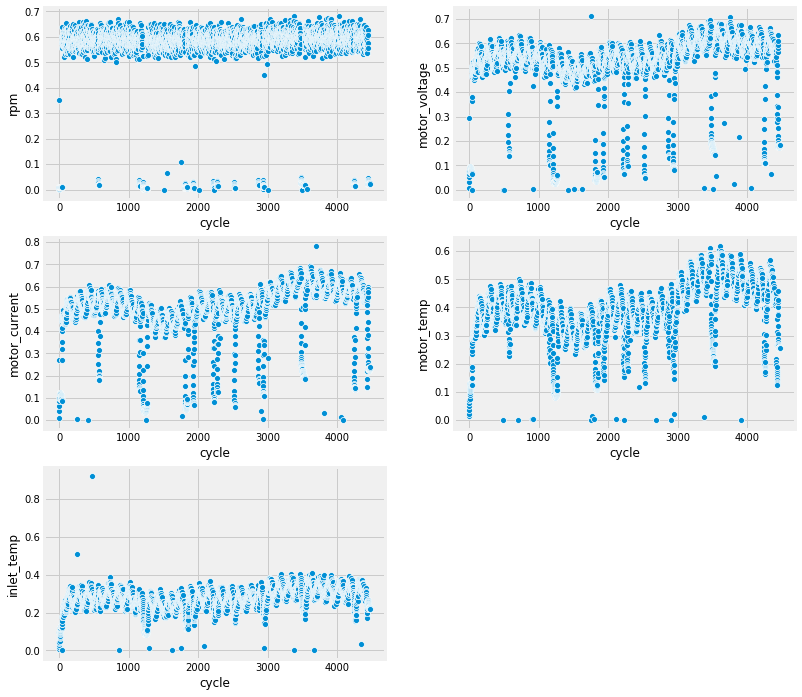

In [69]:
plot(df_test[df_test.unit == 24])

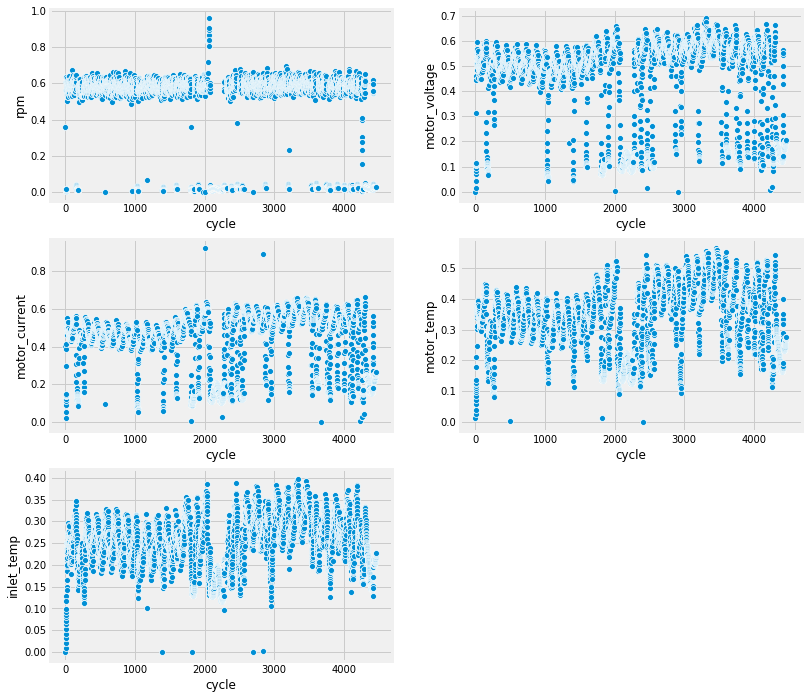

In [70]:
plot(df_test[df_test.unit == 40])

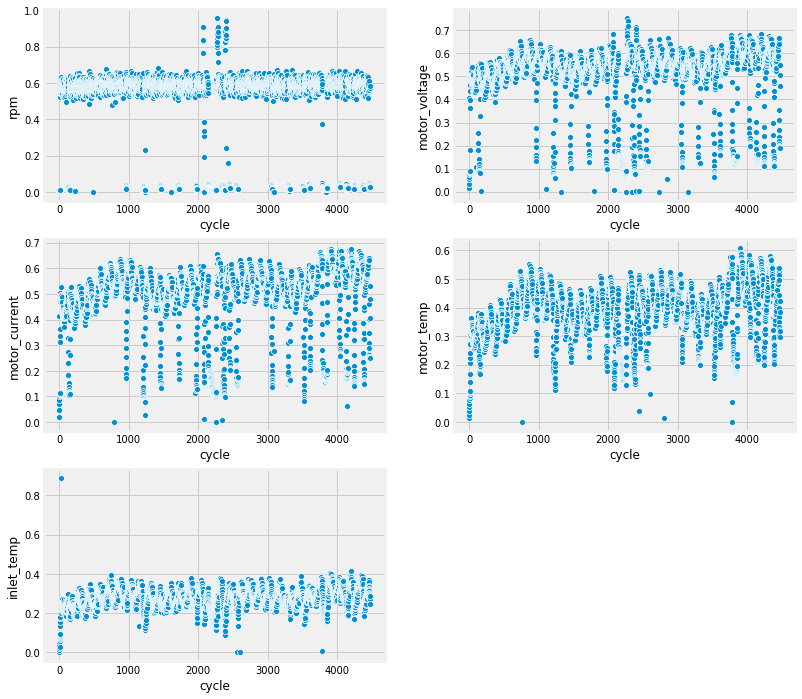

In [71]:
plot(df_test[df_test.unit == 35])

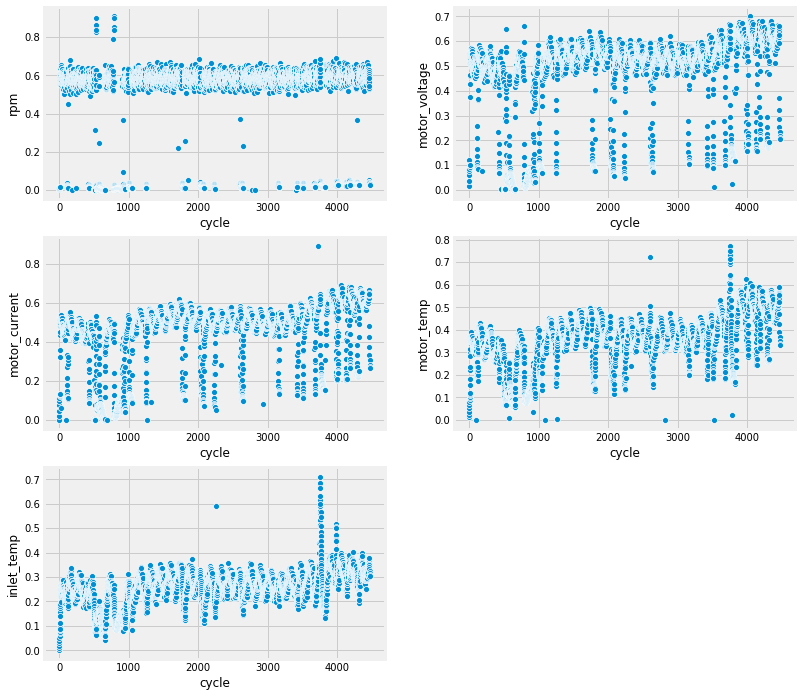

In [72]:
plot(df_test[df_test.unit == 25])

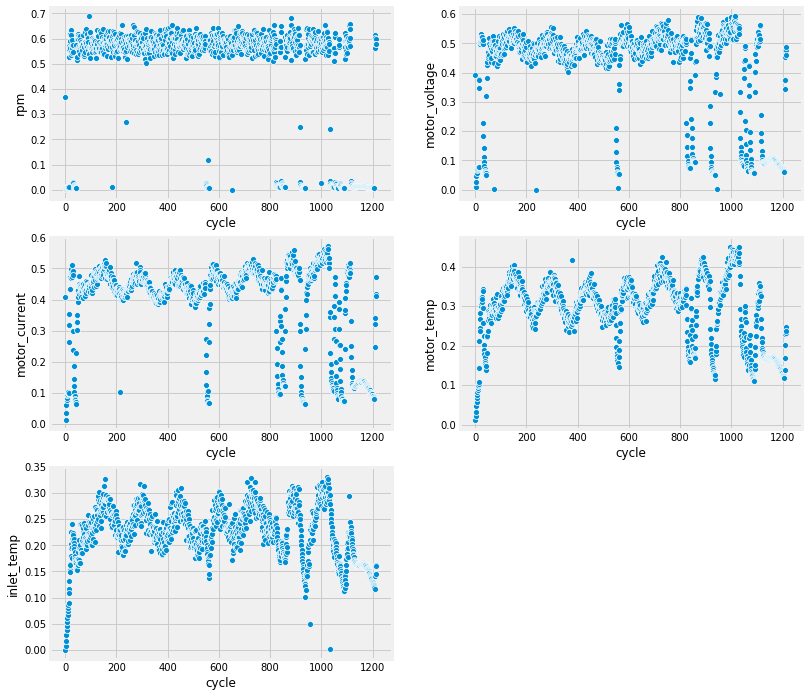

In [73]:
plot(df_test[df_test.unit == 23])

## Conclusion

After the analysis of recorded feature values of different units, I can make following potential conclusions.
- The clustering of units based on their recorded feature values will not help us predict which unit will require maintenance soon.
- For a unit to have a long life, all feature values except rpm should follow wavy pattern as all units with maximum lives' featuer value plots have same.
- RPM should almost remain constant.
- The top active units having highest probabilities are unit 24, 40, 35, 25, 23. From the feature values plots of unit 23, I can say with high confidence that it will fail soon.